## References: 
+ https://pingouin-stats.org/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
import os

### Preliminaries

In [2]:
## Grab data.
behav_path = os.getcwd() + '/ProcessedData/Feedback_Processed_CombinedBehavioralEyetrackingData.csv'
behav_data = pd.read_csv(behav_path)
subjects = behav_data['Subj'].unique()

## Get metadata.
n_trials = max(behav_data['Trial'])
n_games = max(behav_data['Game'])
game_length = len(behav_data.loc[(behav_data['Subj'] == 23) & (behav_data['Game'] == 1)])

# change subj to int
behav_data['Subj'] = behav_data['Subj'].astype(int)

## Add trial-within-game variable.
behav_data['WithinGameTrial'] = behav_data['Trial'] - (behav_data['Game']-1)*game_length
behav_data = behav_data.fillna(0)

## Add learned variable.
behav_data['learned'] = (behav_data['PoL'] > 15)

## Restrict to unlearned games? 
unlearned_only = behav_data.loc[behav_data['learned'] == False]

### 1. Visualize entropy

For illustration, we look at how trial within game (**WithinGameTrial**) and age group (**AgeGroup**) affect **Entropy**.

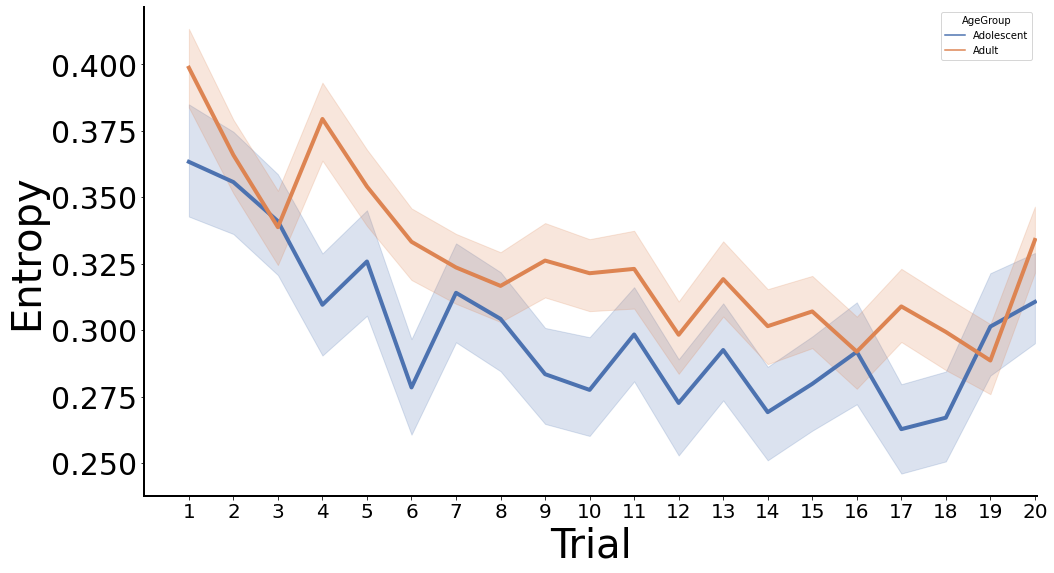

In [3]:
# This line groups by relevant variables (aka factors). 
df = pd.melt(behav_data, col_level=0, id_vars=['Subj','WithinGameTrial','AgeGroup'], value_vars=['Entropy']).dropna()
# df = pd.melt(unlearned_only, col_level=0, id_vars=['Subj','WithinGameTrial','AgeGroup'], value_vars=['Entropy']).dropna()

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = "WithinGameTrial", y="value", hue='AgeGroup', err_style="band", ci=68, data=df, lw=4, palette='deep')
sns.despine()
ax.set_xlim([0,game_length+.05])
ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Trial',fontsize = 40);
yl = ax.set_ylabel('Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

Based on the above plot, we might expect a significant effect of both age group and trial and no interaction.

### 2. Reformat data for 2-way mixed ANOVA

The "melt" command above also reformatted the data to the way that the ANOVA function expects it. 
Let's have a look:

In [4]:
df.head(10)

,Subj,WithinGameTrial,AgeGroup,variable,value
0,23,1,Adolescent,Entropy,0.767231
1,23,2,Adolescent,Entropy,0.324678
2,23,3,Adolescent,Entropy,0.534086
3,23,4,Adolescent,Entropy,0.751248
4,23,5,Adolescent,Entropy,0.996135
5,23,6,Adolescent,Entropy,0.525721
6,23,7,Adolescent,Entropy,0.332279
7,23,8,Adolescent,Entropy,0.896607
8,23,9,Adolescent,Entropy,0.232524
9,23,10,Adolescent,Entropy,0.611740


In [15]:
df_grouped = df.groupby(['Subj','WithinGameTrial','AgeGroup'])['value'].mean().reset_index()

The dependent variable is **Entropy**, and it's coded in the **value** column. The factors we are interested in are **WithinGameTrial** (within-subject) and **AgeGroup** (also between-subject). The **Subj** column is considered the "random effect." For LDM, we need a mixed ANOVA in which one of the factors (**AgeGroup**) is between-subjects. 

Then we can run the model using the *pingouin* package: 

In [23]:
aov = pg.mixed_anova(data=df, dv='value', between='AgeGroup', within='WithinGameTrial',
                     subject='Subj', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2     MS      F    p-unc    np2      eps
---------------  -----  -----  -----  -----  -----  -------  -----  -------
AgeGroup         0.109      1     32  0.109  1.281    0.266  0.038  nan
WithinGameTrial  0.488     19    608  0.026  8.370    0.000  0.207    0.594
Interaction      0.059     19    608  0.003  1.014    0.442  0.031  nan



We observe a significant effect of trial, consistent with the observation that entropy generally decreases over time, but the effect of age is not significant. 

In [119]:
N_adolescents = len(np.unique(df[df['AgeGroup'] == 'Adolescent']['Subj'].values))
N_adults = len(np.unique(df[df['AgeGroup'] == 'Adult']['Subj'].values))

print('Found ' + str(N_adolescents) + ' participants in the adolescents group')
print('Found ' + str(N_adults) + ' participants in the adults group')

Found 12 participants in the adolescents group
Found 22 participants in the adults group


### 3. Exploratory analysis as a function of outcome.

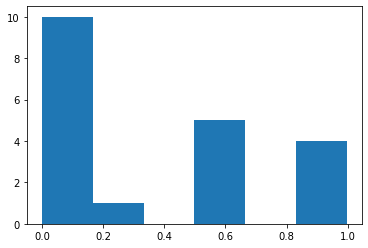

In [120]:
ss = df[(df['Subj'] == 23)]
x = ss[ss['WithinGameTrial'] == 5]['value'].values

_ = plt.hist(x, bins='auto')

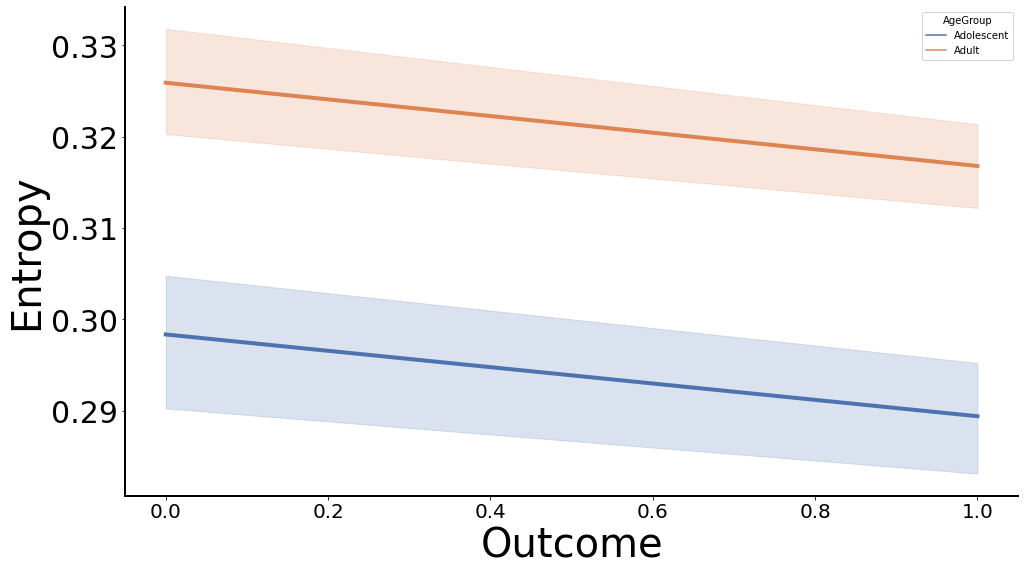

In [122]:
# This line groups by relevant variables (aka factors). 
# df = pd.melt(behav_data, col_level=0, id_vars=['Subj','AgeGroup','Outcome'], value_vars=['Entropy']).dropna()
df = pd.melt(unlearned_only, col_level=0, id_vars=['Subj','Outcome','AgeGroup'], value_vars=['Entropy']).dropna()

fig, ax = plt.subplots(figsize=(16,9))
sns.lineplot(x = "Outcome", y="value", hue='AgeGroup', err_style="band", ci=68, data=df, lw=4, palette='deep')
sns.despine()
# ax.set_xlim([0,game_length+.05])
# ax.set_xticks(np.arange(game_length)+1)
xl = ax.set_xlabel('Outcome',fontsize = 40);
yl = ax.set_ylabel('Entropy',fontsize = 40);
for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(2)
ax.tick_params(axis='x',colors='k')
plt.xticks(fontsize=20);
plt.yticks(fontsize=30);

In [123]:
aov = pg.mixed_anova(data=df, dv='value', between='AgeGroup', within='Outcome',
                     subject='Subj', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
AgeGroup     0.015      1     32  0.015  1.444    0.238  0.043  nan
Outcome      0.001      1     32  0.001  0.296    0.590  0.009    1.000
Interaction  0.000      1     32  0.000  0.138    0.713  0.004  nan

